# Convolutional and Recurrent Neural Networks

In this notebook we'll see the implementation of four models:

- __GenreClassifier__: A CRNN that combines 1D Convolutional, Recurrent (LSTM) and linear layers. An architecture inspired by [Kiran Sanjeevan Cabeza, UrbanSound classification using Convolutional Recurrent Networks in PyTorch](https://github.com/ksanjeevan/crnn-audio-classification)<br>

- __SimpleClassifier__: A simpler version of GenreClassifier.<br>

- __SimpleClassifier_RNN__: A Recurrent Neural Network that uses LSTM followed by Linear Layers.<br>

- __SimpleClassifier_CNN__ : A Convolutional Neural Network that uses 1D convolutions followed by Linear Layers.<br>



## Import packages and allocate device

In [46]:
import numpy as np
import os
from os.path import isfile
import wandb


import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sn
from sklearn.metrics import confusion_matrix
import sklearn as skl
from IPython import display

%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd


In [2]:
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0) # make plot background transparent
})

Allocate device

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)
print(device)

cuda:0


## Load data

Load the train, validation and test arrays stored in .npz files

In [4]:
npzfile = np.load('data/shuffled_train.npz') # load the data
X_train = npzfile['arr_0'] # features of the audio tracks 
y_train = npzfile['arr_1'] # labels : genres as numbers
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394,)


In [5]:
npzfile = np.load('data/shuffled_valid.npz') 
X_val = npzfile['arr_0'] # features of the audio tracks
y_val = npzfile['arr_1'] # labels : genres as numbers
print(X_val.shape, y_val.shape) 

(800, 640, 128) (800,)


In [6]:
npzfile = np.load('data/test_arr.npz') 
X_test = npzfile['arr_0'] # features of the audio tracks
y_test = npzfile['arr_1'] # labels : genres as numbers
print(X_test.shape, y_test.shape) 

(800, 640, 128) (800,)


We'll map the different genres to numbers, to retrieve them, we'll create dictionary and its reverse version.

In [7]:
# Create a dictionary to map the genres to numbers corresponding to classes
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

# Create a dictionary to map the class numbers to genres
reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


Check that the data has been succesfully imported by plotting a spectogram

Electronic


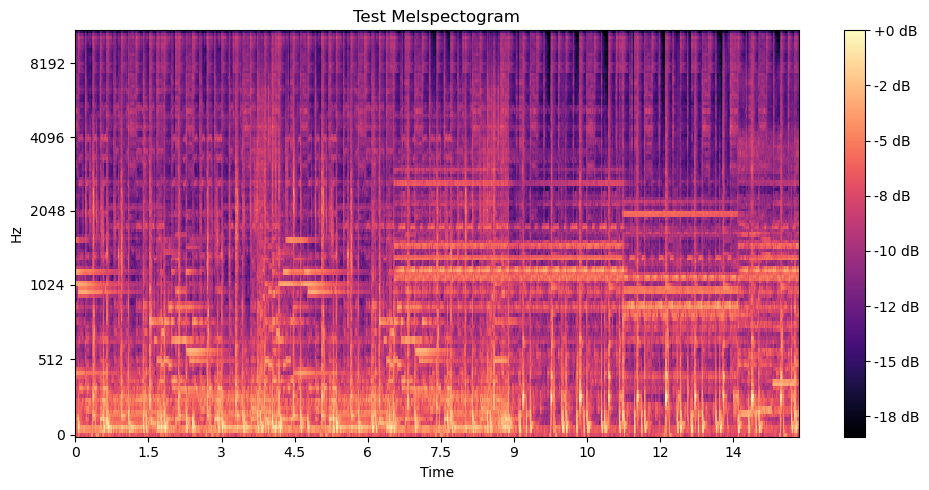

In [8]:
num = 5300 # number of the audio track to be displayed
spectogram = X_train[num] # spectogram of the audio track
genre = np.argmax(y_train[num]) # genre of the audio track
print(reverse_map[genre]) # print the genre of the audio track

plt.figure(figsize=(10, 5)) 
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Data preparation

Create our dataset <code>MusicDataset</code>. It'll have the number of tracks as length and when called with an index it'll return the information about the track in that position, that is, an array with the spectogram data (time_frames, frequency_bins) and the number corresponding to the genre of the track.

In [9]:
class MusicDataset():
    def __init__(self, x, y):
        self.x = x # spectograms
        self.y = y # genres
        self.n = x.shape[0] # number of audio tracks
        
    def __getitem__(self, index):
        return self.x[index], self.y[index] # return the spectogram and the genre of the audio track

    def __len__(self):
        return self.n # return the number of audio tracks

Create the train, validation and test sets and loaders

In [19]:
batch_size =64 # number of audio files per batch
num_classes = len(dict_genres) # number of genres

train_set = MusicDataset(X_train, y_train)
val_set = MusicDataset(X_val, y_val)
test_set = MusicDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size= batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=False)

To get a better undestranding of the data, print some information about the data we will use for the model.

In [11]:
for batch in train_loader:
    audio_batch, genres = batch

    print(f'We have {audio_batch.shape[0]} tracks in the batch.\n')
    print(f"There are {audio_batch[0].shape[0]} time frames in the spectogram of the first track of the batch,\neach of them correspond to a specific portion of the audio signal.\n")
    print(f'There are {audio_batch[0].shape[1]} frequency bins in the spectogram of the first track of the batch,\neach bin represents the energy or magnitude of the audio signal within that particular frequency band.\n')
    
    print('To sum up, for each track, we have 640 time frames, each one of them represented by 128 frequency bins.\n')

    print(f'And this track is from genre {genres[0]}, which is {reverse_map[int(genres[0])]}.')
    break

We have 32 tracks in the batch.

There are 640 time frames in the spectogram of the first track of the batch,
each of them correspond to a specific portion of the audio signal.

There are 128 frequency bins in the spectogram of the first track of the batch,
each bin represents the energy or magnitude of the audio signal within that particular frequency band.

To sum up, for each track, we have 640 time frames, each one of them represented by 128 frequency bins.

And this track is from genre 6, which is Pop.


### CNN - RNN Model

__GenreClassifier__: A CRNN that combines 1D Convolutional, Recurrent (LSTM) and linear layers. An architecture inspired by [Kiran Sanjeevan Cabeza, UrbanSound classification using Convolutional Recurrent Networks in PyTorch](https://github.com/ksanjeevan/crnn-audio-classification)

In [38]:
class GenreClassifier(nn.Module):
    def __init__(self, num_classes, init = True, filters = [128, 256, 64]):
        super(GenreClassifier, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=640, out_channels=filters[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(filters[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            nn.Conv1d(in_channels=filters[0], out_channels=filters[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(filters[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            nn.Conv1d(in_channels=filters[1], out_channels=filters[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(filters[2]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )
        
        if init == True:
            for i in [0,5,10]:
                nn.init.kaiming_normal_(self.conv_layers[i].weight.data)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=16, hidden_size=64, batch_first=True, bidirectional=True)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(16*filters[1]*2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, filters[1]),
            nn.BatchNorm1d(filters[1]),
            nn.ReLU(inplace=True),
            nn.Linear(filters[1], num_classes),
        )

        if init == True:
            for i in [1,5,8]:
                nn.init.kaiming_normal_(self.fc_layers[i].weight.data)
        
    def forward(self, x):
        
        # (batch_size, 640, 128)

        # Apply convolutional layers
        x = self.conv_layers(x) 

        # Apply LSTM layer
        x, (h_n, _) = self.lstm(x)

        x = x.reshape(x.size(0), -1)
        
        # Apply fully connected layer
        x = self.fc_layers(x) # (batch_size, num_classes)

        return x

__SimpleClassifier__: A simpler version of GenreClassifier.

In [56]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_classes, init = True, filters = [64, 16]):
        super(SimpleClassifier, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=640, out_channels=filters[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(filters[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            nn.Conv1d(in_channels=filters[0], out_channels=filters[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(filters[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )
        
        if init == True:
            for i in [0,5]:
                nn.init.kaiming_normal_(self.conv_layers[i].weight.data)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True, bidirectional=True)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*filters[1], 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

        if init == True:
            for i in [1,5,8]:
                nn.init.kaiming_normal_(self.fc_layers[i].weight.data)
        
    def forward(self, x):
        
        # (batch_size, 640, 128)

        # Apply convolutional layers
        x = self.conv_layers(x) 

        # Apply LSTM layer
        x, (h_n, _) = self.lstm(x)
    
        x = x.reshape(x.size(0), -1) 
        
        # Apply fully connected layer
        x = self.fc_layers(x) # (batch_size, num_classes)

        return x

__SimpleClassifier_CNN__ : A Convolutional Neural Network that uses 1D convolutions followed by Linear Layers.<br>


In [16]:
class SimpleClassifier_CNN(nn.Module):
    def __init__(self, num_classes, init = True, filters = [64, 32, 16]):
        super(SimpleClassifier_CNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=640, out_channels=filters[0], kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            nn.Conv1d(in_channels=filters[0], out_channels=filters[1], kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
            nn.Conv1d(in_channels=filters[1], out_channels=filters[2], kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )
        
        if init == True:
            for i in [0,4,8]:
                nn.init.kaiming_normal_(self.conv_layers[i].weight.data)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16*filters[2], 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

        if init == True:
            for i in [1,5,8]:
                nn.init.kaiming_normal_(self.fc_layers[i].weight.data)
        
    def forward(self, x):
        
        # (batch_size, 640, 128)
        # Apply convolutional layers
        x = self.conv_layers(x) 

        x = x.reshape(x.size(0), -1) 
        
        # Apply fully connected layer
        x = self.fc_layers(x) # (batch_size, num_classes)

        return x

__SimpleClassifier_RNN__: A Recurrent Neural Network that uses LSTM followed by Linear Layers.<br>


In [17]:
class SimpleClassifier_RNN(nn.Module):
    def __init__(self, num_classes, num_layers, hidden_dim, init = True):
        super(SimpleClassifier_RNN, self).__init__()

        # LSTM layer
        self.rnn = nn.LSTM(input_size = 128, hidden_size = hidden_dim, num_layers = num_layers, batch_first=True)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(640*hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )

        if init == True:
            for i in [1,5,8]:
                nn.init.kaiming_normal_(self.fc_layers[i].weight.data)

    def forward(self, x):
        # (batch_size, 640, 128)

        # Apply recurrent layers (LSTM)
        x, _ = self.rnn(x) 

        x = x.reshape(x.size(0), -1) 
        
        # Apply fully connected layer
        x = self.fc_layers(x) # (batch_size, num_classes)

        return x
    
    def init_hidden(self, batch_size): # Initialize the hidden state of the RNN to zeros
        weight = next(self.parameters()).data

        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(), weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        

Example of the initialisation of the RNN model:

In [87]:
model = SimpleClassifier_RNN(num_classes=8, num_layers = 2, hidden_dim = 256)
print(model)
model = model.to(device, dtype=torch.float64)

SimpleClassifier_RNN(
  (rnn): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=163840, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=64, out_features=8, bias=True)
  )
)


## Training and Validation

### Using Weights and Biases

Login in Weights and Biases, please provide your API KEY

In [73]:
wandb.login()
os.environ["WANDB_API_KEY"] = ' ' #introduce API KEY
os.environ['WANDB_NOTEBOOK_NAME'] = 'CRNN_model.ipynb'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Configure type of model and hyperparameters. 

In [78]:
config = dict(n_classes = 8,
    batch_size = 32,
    lambda_l2 = 1e-5,
    learning_rate = 0.0001,
    architecture = "RNN",
    epochs = 25,
    init = True,
    filters = [64, 32, 16],
    num_layers = 2,
    hidden_dims = 256)

Training and validation functions

In [79]:
def train(epoch, criterion, model, optimizer, loader):
    
    wandb.watch(model, criterion, log = 'all', log_freq=10)
    total_loss = 0.0 #initialize the loss

    model.train() #set the model to training mode

    for batch_idx, (track, target) in enumerate(loader): #for each batch

        optimizer.zero_grad() #zero the gradients

        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = model(track) #get the output of the model

        loss = criterion(output, target) #calculate the loss
        loss.backward() #backpropagate the loss
        optimizer.step() #update the weights
        
         # print loss every N iterations
        if batch_idx % 100 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(track), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))

        total_loss += loss.item()  #.item() is very important here? Why?

    wandb.log({'loss': total_loss/len(loader.dataset)})

    return total_loss / len(loader.dataset)

# Validation function
def validate(criterion, model, loader): 

    val_loss = 0 #initialize the loss
    correct = 0

    model.eval() #set the model to evaluation mode

    for track, target in loader: #for each batch

        target = target.long() #squeeze the target and convert it to long
       
        target, track = target.to(device), track.to(device) #move the data to the device

        output = model(track) #get the output of the model

        loss = criterion(output, target) #calculate the loss

        val_loss += loss.item() # sum up batch loss               

        pred = output.data.max(1, keepdim=True)[1]

        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset) #calculate the average loss

    # print validation loss and accuracy
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))
    
    wandb.log({'loss': val_loss/len(loader.dataset), 'accuracy': accuracy})

    return val_loss, accuracy

Create function to create the datasets, initilise the model, criterion and opitmiser.  We'll use ``CrossEntropyLoss`` as criterion, as it combines both ``LogSoftmax`` and ``NLLLoss``; and ``Adam`` as optimiser.

In [80]:
def make (config, X_train, y_train, X_val, y_val) :

    # Make the data
    train_set = MusicDataset(X_train, y_train)
    val_set = MusicDataset(X_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=False)

    # Make the model
    if config.architecture == 'SimpleCRNN':

        model = SimpleClassifier(config.n_classes, config.init, config.filters)
        model = model.to(device, dtype=torch.float64)
    
    elif config.architecture == 'CRNN':

        model = GenreClassifier(config.n_classes, config.init, config.filters)
        model = model.to(device, dtype=torch.float64)

    elif config.architecture == 'CNN':

        model = SimpleClassifier_CNN(config.n_classes, config.init, config.filters)
        model = model.to(device, dtype=torch.float64)

    elif config.architecture == 'RNN':

        model = SimpleClassifier_RNN(config.n_classes, config.num_layers, config.hidden_dims, config.init)
        model = model.to(device, dtype=torch.float64)
    
    # Make the loss and optimizer
    criterion = nn. CrossEntropyLoss ()
    optimizer = torch.optim.Adam(
    model.parameters(), lr =config.learning_rate, weight_decay=config.lambda_l2)
    return model, train_loader, val_loader, criterion, optimizer

Create model pipeline

In [76]:
def model_pipeline(config, X_train, y_train, X_val, y_val):
    # tell wandb to get started
    run = wandb.init(project="MusicGenreClassification" , config=config)
        
    # access all Hs through wandb.config, so logging matches execution!
    config = wandb.config
        
    # make the model, data, and optimization problem
    model, train_loader, val_loader, criterion, optimizer = make(config, X_train, y_train, X_val, y_val)
    print (model)

    losses = {"train": [], "val": []}
    for epoch in range(config.epochs): 
        
        train_loss = train(epoch, criterion, model, optimizer, train_loader)
        val_loss, accuracy =  validate(criterion, model, val_loader)
        losses["train"].append(train_loss) #save the training loss
        losses["val"].append(val_loss) #save the validation loss
            
        display.clear_output(wait=True) 

        plt.plot(losses["train"], label="training loss") #plot the training loss
        plt.plot(losses["val"], label="validation loss") #plot the validation loss

        plt.legend()
        plt.pause(0.000001)
        plt.show()

        print(f'Accuracy: {accuracy:.2f}%') 
    
    run.finish()
    return model

Run training and validation

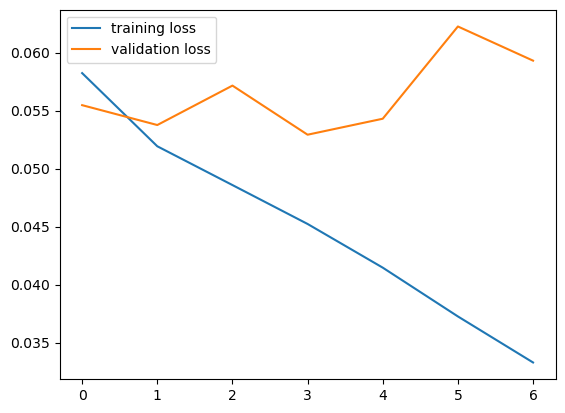

Accuracy: 34.50%
torch.Size([32, 163840])
Train Epoch: 7 [0/6394 (0%)]	Loss: 0.719793
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32, 163840])
torch.Size([32

In [89]:
model = model_pipeline(config, X_train, y_train, X_val, y_val)


The following commented cells are a Early Stopping implementation that was used to check performance improvements. As it wasn't useful, the code remained commented but not deleted in case that it eventually becomes useful.

In [ ]:
"""
def model_pipeline_earlystopping(config, X_train, y_train, X_val, y_val):
    # tell wandb to get started
    run = wandb.init(project="MusicGenreClassification" , config=config)
        
    # access all Hs through wandb.config, so logging matches execution!
    config = wandb.config
        
    # make the model, data, and optimization problem
    model, train_loader, val_loader, criterion, optimizer = make(config, X_train, y_train, X_val, y_val)
    print (model)
    best_err = -np.Inf
    wait = 0
    patience = 0

    losses = {"train": [], "val": []}
    for epoch in range(config.epochs): 
        
        train_loss = train(epoch, criterion, model, optimizer, train_loader)
        val_loss, accuracy =  validate(criterion, model, val_loader)
        losses["train"].append(train_loss) #save the training loss
        losses["val"].append(val_loss) #save the validation loss

        # Control here when to stop the model
        if val_loss < best_err:
            best_err = val_loss
            # torch.save(model.state_dict(), PATH)
            self.wait = 0
        if wait >= patience:
            break
            
        display.clear_output(wait=True) 

        plt.plot(losses["train"], label="training loss") #plot the training loss
        plt.plot(losses["val"], label="validation loss") #plot the validation loss

        plt.legend()
        plt.pause(0.000001)
        plt.show()

        print(f'Accuracy: {accuracy:.2f}%') 
    
    run.finish()
    return model
"""

In [ ]:
#model = model_pipeline_earlystopping(config, X_train, y_train, X_val, y_val)

accuracy,▁
loss,█▁
accuracy,13.25
loss,0.00013


SimpleClassifier(
  (conv_layers): Sequential(
    (0): Conv1d(640, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5)

accuracy,▁
loss,█▁
accuracy,20.625
loss,0.00013


### Without Weights and Biases

Define training and validation functions

In [51]:
def train(epoch, criterion, model, optimizer, loader):

    total_loss = 0.0 #initialize the loss

    model.train() #set the model to training mode

    for batch_idx, (track, target) in enumerate(loader): #for each batch

        optimizer.zero_grad() #zero the gradients

        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = model(track) #get the output of the model

        loss = criterion(output, target) #calculate the loss
        loss.backward() #backpropagate the loss
        optimizer.step() #update the weights
        
         # print loss every N iterations
        if batch_idx % 100 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(track), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))

        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

# Validation function
def validate(criterion, model, loader): 

    val_loss = 0 #initialize the loss
    correct = 0

    model.eval() #set the model to evaluation mode

    for track, target in loader: #for each batch

        target = target.long() #squeeze the target and convert it to long
       
        target, track = target.to(device), track.to(device) #move the data to the device

        output = model(track) #get the output of the model

        loss = criterion(output, target) #calculate the loss

        val_loss += loss.item() # sum up batch loss               

        pred = output.data.max(1, keepdim=True)[1]

        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset) #calculate the average loss

    # print validation loss and accuracy
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))

    return val_loss, accuracy

### CRNN vs Simple CRNN

#### CRNN

Initialise the model

In [50]:
model = GenreClassifier(num_classes=8)
print(model)
model = model.to(device, dtype=torch.float64)

GenreClassifier(
  (conv_layers): Sequential(
    (0): Conv1d(640, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(256, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(16, 64, batch_first=True, bidire

Set hyperparameters, optimiser and criterion.  We'll use ``CrossEntropyLoss`` as criterion, as it combines both ``LogSoftmax`` and ``NLLLoss``; and ``Adam`` as optimiser.

In [49]:
learning_rate = 0.001
lambda_l2 = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
criterion = torch.nn.CrossEntropyLoss()

Run training and validation

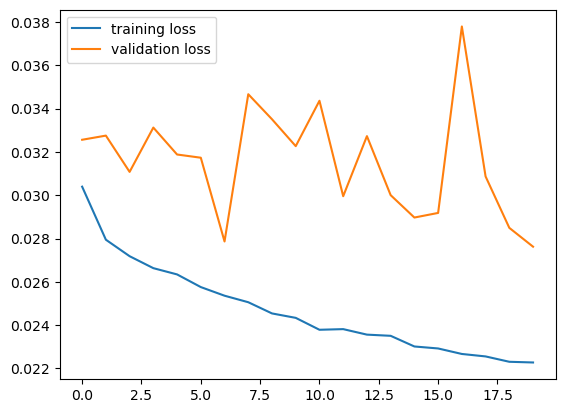

Accuracy: 35.62%


In [42]:
losses = {"train": [], "val": []}
n_epochs = 20
for epoch in range(n_epochs): 

    train_loss = train(epoch, criterion, model, optimizer, train_loader) #train the model
    val_loss, accuracy = validate(criterion, model, val_loader) #validate the model
    losses["train"].append(train_loss) #save the training loss
    losses["val"].append(val_loss) #save the validation loss
    
    display.clear_output(wait=True) 

    plt.plot(losses["train"], label="training loss") #plot the training loss
    plt.plot(losses["val"], label="validation loss") #plot the validation loss

    plt.legend()
    plt.pause(0.000001)
    plt.show()

print(f'Accuracy: {accuracy:.2f}%') 

Testing and Confusion Matrix

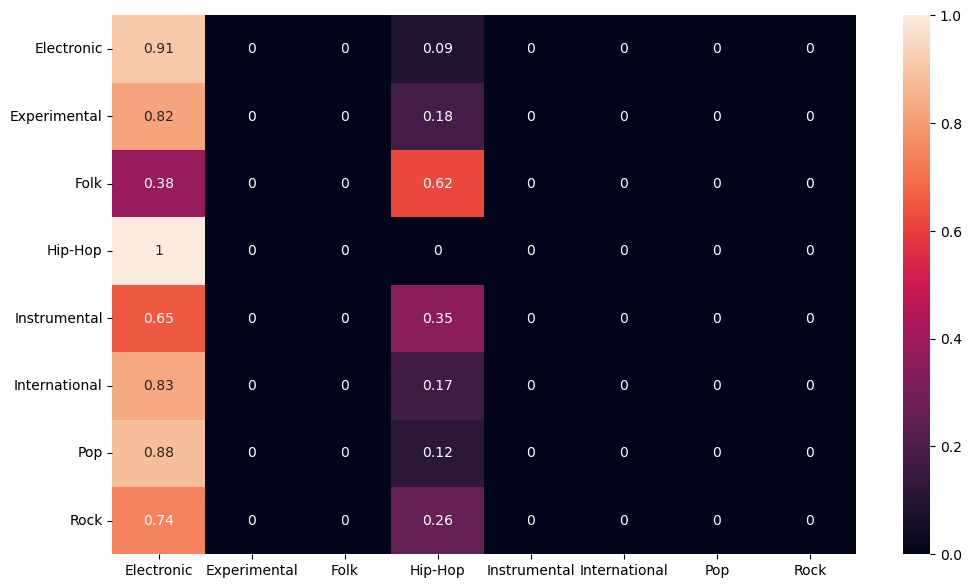

In [47]:
y_pred = []
for track, target in test_loader: #for each batch
        m = nn.LogSoftmax(dim=1)
        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = m(model(track)) #get the output of the model      
        pred = output.data.max(1, keepdim=True)[1]
        y_pred.append(pred)

y_pred = torch.cat(y_pred)
y_pred = y_pred.view(-1)
y_pred = y_pred.cpu()

c_m = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(c_m / np.sum(c_m, axis=1)[:, None], index = [i for i in dict_genres.keys()], columns = [i for i in dict_genres.keys()])

plt.figure(figsize = (12,7))
plt.title('')
sn.heatmap(df_cm, annot=True)

plt.show()

#### Simple CRNN

In [57]:
simple_model = SimpleClassifier(num_classes=8)
print(simple_model)
simple_model = simple_model.to(device, dtype=torch.float64)

SimpleClassifier(
  (conv_layers): Sequential(
    (0): Conv1d(640, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(32, 64, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5)

In [58]:
learning_rate = 0.001
lambda_l2 = 1e-3
optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
criterion = torch.nn.CrossEntropyLoss()

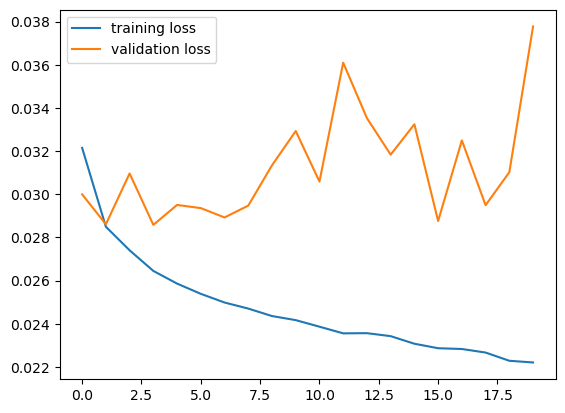

Accuracy: 28.12%


In [59]:
losses = {"train": [], "val": []}
n_epochs = 20
for epoch in range(n_epochs): 

    train_loss = train(epoch, criterion, simple_model, optimizer, train_loader) #train the model
    val_loss, accuracy = validate(criterion, simple_model, val_loader) #validate the model
    losses["train"].append(train_loss) #save the training loss
    losses["val"].append(val_loss) #save the validation loss
    
    display.clear_output(wait=True) 

    plt.plot(losses["train"], label="training loss") #plot the training loss
    plt.plot(losses["val"], label="validation loss") #plot the validation loss

    plt.legend()
    plt.pause(0.000001)
    plt.show()

print(f'Accuracy: {accuracy:.2f}%') 

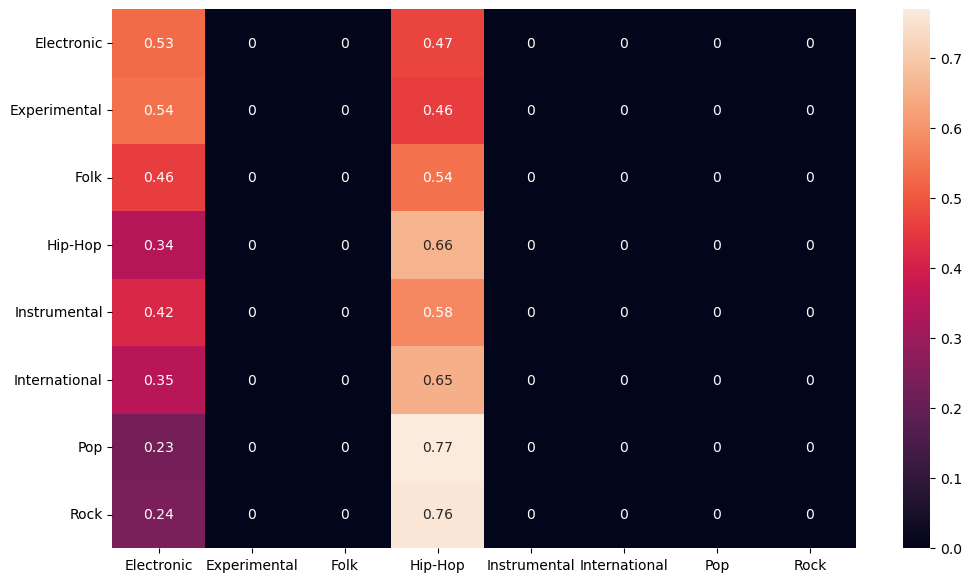

In [60]:
y_pred = []
for track, target in test_loader: #for each batch
        m = nn.LogSoftmax(dim=1)
        target = target.long() #squeeze the target and convert it to long
        
        target, track = target.to(device), track.to(device) #move the data to the device

        output = m(simple_model(track)) #get the output of the model      
        pred = output.data.max(1, keepdim=True)[1]
        y_pred.append(pred)

y_pred = torch.cat(y_pred)
y_pred = y_pred.view(-1)
y_pred = y_pred.cpu()

c_m = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(c_m / np.sum(c_m, axis=1)[:, None], index = [i for i in dict_genres.keys()], columns = [i for i in dict_genres.keys()])

plt.figure(figsize = (12,7))
plt.title('')
sn.heatmap(df_cm, annot=True)

plt.show()

### Conclusions

As seen in the plots and results above, neither of them performs well on this task, with an accuracy around 35% (depending on the run) in both models, being the simple model the one with a slightly highest accuracy among them (in most cases).

Based on that the training curves our belief is that the models overfit, learning the training set, which translates in poor validation performance. 

From different available solutions to overfitting, we could simplify the model, which we have done with Simple CRNN, RNN or CNN, or obtain or generate more data.

However, when taking a look at the confusions matrix we can observe that these models have learned to only differentiate between Hip-Hop and Electronic songs and without good results, which makes us conclude that further experimentation and investigation needs to be done regarding the data to use as input and the kind of architecture to use.